In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [2]:
def getUniqueModelsForTicker(tickerToTrade):
    allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    for i in range(len(uniqueModels)):
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    return uniqueModels

In [3]:
def getAllUniqueModels():
    allModels = portfolio.getModels(ticker=None, returnEntireObject=True)
    print("***ORIGINAL MODELS***")
    for modelEntity in allModels:
        model = modelEntity["model"]
        print(model.describe())
    print("***UNIQUE MODELS***")
    uniqueModels, uniqueEntities = portfolioGeneration.getUniqueModels(allModels)
    uniqueModelsToKeep = []
    for i in range(len(uniqueModels)):
        uniqueModelsToKeep.append(uniqueModels[i])
            
        model = uniqueModels[i]
        print(model.describe())
        for key in sorted(list(uniqueEntities[i].keys())):
            if key == "model":
                continue
            print(key, uniqueEntities[i][key])
        print("-")
    print("MODELS KEPT:", len(uniqueModelsToKeep))
    return uniqueModelsToKeep

In [4]:
uniqueModels = getAllUniqueModels()

***ORIGINAL MODELS***
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 25)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 150)
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 50)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 50)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 100)
((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)
((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 50)
((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 150)
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 300)
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 150)
((10, ('KBE', 29, 4, None, 3), 15, 'EEM'), 10, 100)
((2

In [5]:
# uniqueModels = getUniqueModelsForTicker("KRE")

***ORIGINAL MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
***UNIQUE MODELS***
((5, ('IWF', 34, None, 6, 3), 5, 'KRE'), 5, 25)
25TH PERCENTILE SHARPE -0.6337067875941056
ACTIVITY 0.8881118881118881
ALPHA 0.007988175323716528
ANNUALIZED RETURN -0.011486281434638368
BETA 0.0743272730028087
FACTOR SHARPE 0.5893244467631594
MIN ROLLING SHARPE -1.3928904549409589
OOS_ACTIVITY 0.8809523809523809
OOS_ALPHA 0.09336759044226908
OOS_ANNUALIZED RETURN 0.0924040888470603
OOS_BETA 0.007300853474550487
OOS_FACTOR SHARPE 1.5828331654699737
OOS_RAW BETA 0.11234528721040882
OOS_RELATIVE SHARPE -0.21072972318748795
OOS_RELATIVE SHARPE SLIPPAGE -0.6098572118915898
OOS_SHARPE 1.2492831706585108
OOS_SHARPE DIFFERENCE -0.33354999481146286
OOS_SHARPE DIFFERENCE SLIPPAGE -0.9653022211830575
OOS_SHARPE SLIPPAGE DECAY -0.6317522263715947
OOS_STABILITY 0.7319827336651228
OOS_TOTAL DAYS SEEN 252
OOS_TREYNOR -35.03359140763217
RAW BETA 0.04255704328814437
RELATIVE SHARPE -1.0663703126798745
RELATIVE SHA

In [5]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    aggregateSlippageReturns = None
    cleanedModels = []
    for mod in allModels:
        
        try:
            algoReturn, algoPredictions, algoSlippageAdjustedReturn = dataAck.getModelData(mod)
            print(mod.describe())
            algoReturn.columns = [str(mod.describe())]
            algoPredictions.columns = [str(mod.describe())]
            algoSlippageAdjustedReturn.columns =  [str(mod.describe())]
            if aggregateReturns is None:
                aggregateReturns = algoReturn
                aggregatePredictions = algoPredictions
                aggregateSlippageReturns = algoSlippageAdjustedReturn
            else:
                aggregateReturns = aggregateReturns.join(algoReturn)
                aggregatePredictions = aggregatePredictions.join(algoPredictions)
                aggregateSlippageReturns = aggregateSlippageReturns.join(algoSlippageAdjustedReturn)
            cleanedModels.append(mod)
        except:
            print("SKIPPING", mod.describe())
    return aggregateReturns, aggregatePredictions, aggregateSlippageReturns, cleanedModels

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
            
    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions, modelSlippageReturns, cleanedModels = generateAllReturnsFromCache(uniqueModels)
    
    return cleanedModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [6]:
factorToTrade = "SPY"
uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade)

((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)
((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)
((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)
((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 300)
((10, ('KBE', 29, 4, None, 3), 15, 'EEM'), 10, 25)
((5, ('XBI', 12, None, 9, 2), 15, 'IVE'), 5, 25)
((22, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 22, 50)
((10, ('FXE', 27, 8, None, 3), 7, 'RSP'), 10, 25)
((10, ('IWB', 16, None, None, 1), 15, 'VNQ'), 10, 25)
((44, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 44, 25)
((44, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 44, 100)
((10, ('IWB', 42, None, 13, 1), 10, 'LQD'), 10, 150)
((10, ('GLD', 11, 1, 14, 1), 15

In [7]:
display(joinedData)

,Adj_Close_IYR,Adj_Close_VTV,Adj_Close_VGT,Adj_Close_XLV,Adj_Close_RSP,Adj_Close_LQD,Adj_Close_SLV,Adj_Close_EWW,Adj_Close_EEM,Adj_Close_IVE,Adj_Close_VNQ,Adj_Close_SPY
Date,,,,,,,,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.742226
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.939539
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.998702
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.294703
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.413091
1993-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.393328
1993-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.393328
1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.196015
1993-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.235477


TICKER SHARPE 0.47470554497 SHARPE 0.871064614758 SLIPPAGE SHARPE 0.731281667465


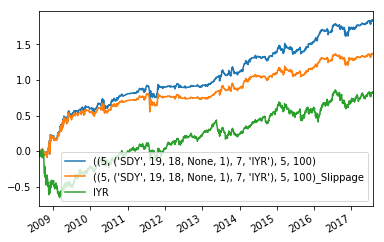

TICKER SHARPE 0.496407017052 SHARPE 0.923274951294 SLIPPAGE SHARPE 0.818193816883


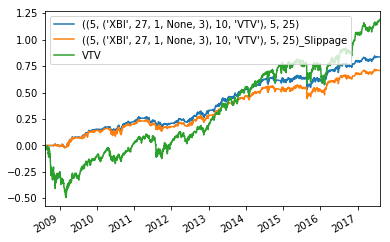

TICKER SHARPE 0.54405501268 SHARPE 0.89358803944 SLIPPAGE SHARPE 0.817737930784


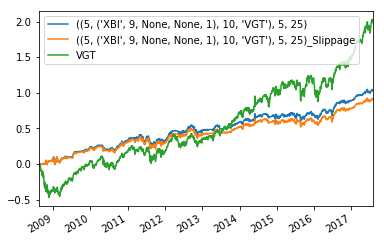

TICKER SHARPE 0.502106619253 SHARPE 0.728601718665 SLIPPAGE SHARPE 0.530182942312


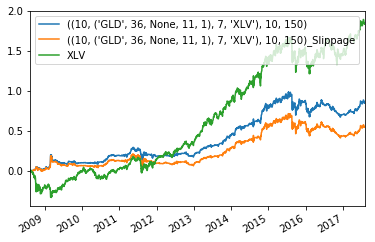

TICKER SHARPE 0.621650559285 SHARPE 0.701620770301 SLIPPAGE SHARPE 0.524916143387


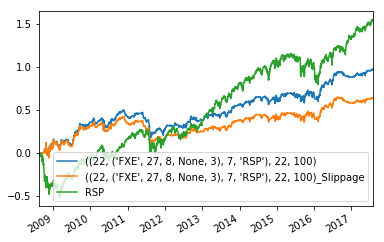

TICKER SHARPE 0.54405501268 SHARPE 0.84557836968 SLIPPAGE SHARPE 0.781577983478


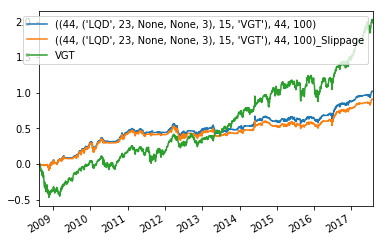

TICKER SHARPE 0.79010737818 SHARPE 1.14974983989 SLIPPAGE SHARPE 0.664468965647


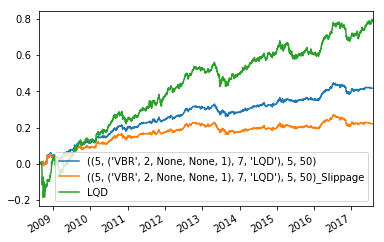

TICKER SHARPE 0.209524925239 SHARPE 0.800254861986 SLIPPAGE SHARPE 0.734395450159


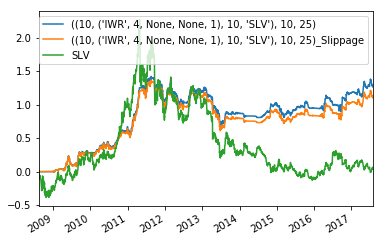

TICKER SHARPE 0.79010737818 SHARPE 0.906955258341 SLIPPAGE SHARPE 0.690219519189


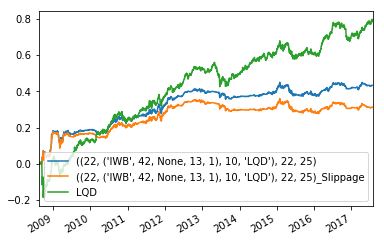

TICKER SHARPE 0.469084443663 SHARPE 0.738550214017 SLIPPAGE SHARPE 0.656474287933


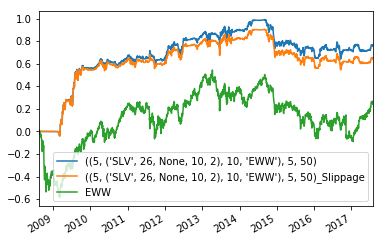

TICKER SHARPE 0.502106619253 SHARPE 0.769515460068 SLIPPAGE SHARPE 0.678505375634


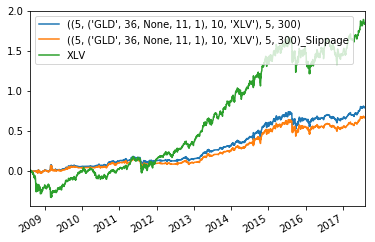

TICKER SHARPE 0.521027813514 SHARPE 0.646608039863 SLIPPAGE SHARPE 0.617862602313


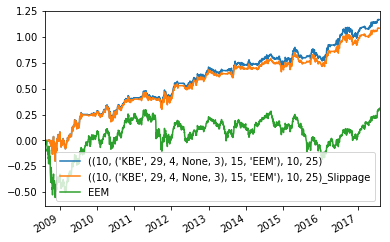

TICKER SHARPE 0.380570028699 SHARPE 0.975424227005 SLIPPAGE SHARPE 0.927568439053


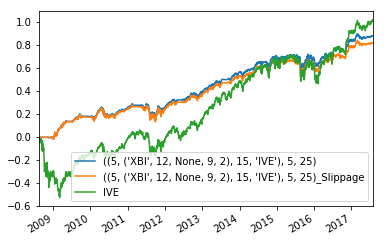

TICKER SHARPE 0.430399256749 SHARPE 0.748231039801 SLIPPAGE SHARPE 0.615239510301


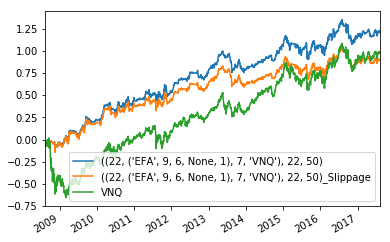

TICKER SHARPE 0.621650559285 SHARPE 0.613192392773 SLIPPAGE SHARPE 0.39843531732


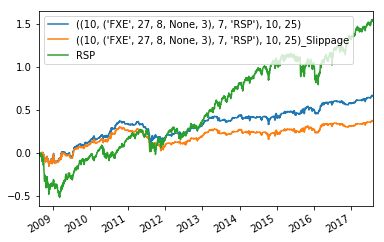

TICKER SHARPE 0.430399256749 SHARPE 0.641831501235 SLIPPAGE SHARPE 0.609495699196


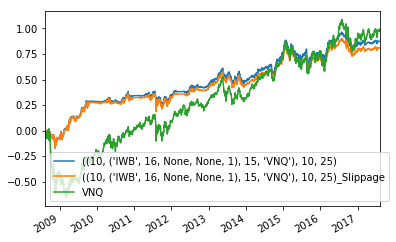

TICKER SHARPE 0.502106619253 SHARPE 1.25097066411 SLIPPAGE SHARPE 1.17914436984


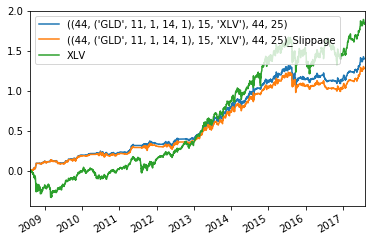

TICKER SHARPE 0.430399256749 SHARPE 0.484201140007 SLIPPAGE SHARPE 0.388390511324


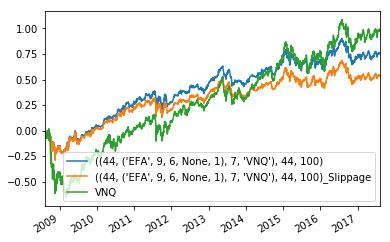

TICKER SHARPE 0.79010737818 SHARPE 0.728267918717 SLIPPAGE SHARPE 0.506789023329


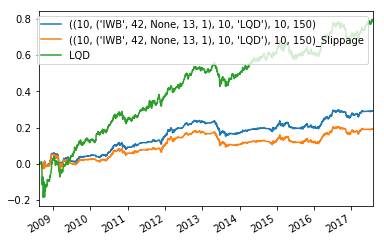

TICKER SHARPE 0.502106619253 SHARPE 0.869655148522 SLIPPAGE SHARPE 0.807193548208


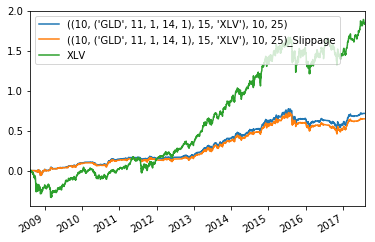

TICKER SHARPE 0.502106619253 SHARPE 0.832674516749 SLIPPAGE SHARPE 0.770681031817


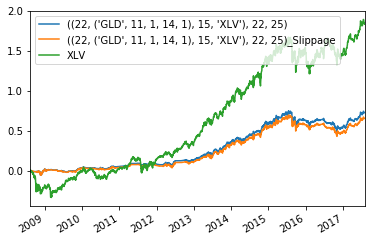

In [8]:
##PERFORM SANITY CHECK
import empyrical
import portfolioGeneration
import matplotlib.pyplot as plt
for i in range(len(modelReturns.columns)):
    item = modelReturns.columns[i]
    slipper = modelSlippageReturns[[modelReturns.columns[i]]]
    slipper.columns = [modelReturns.columns[i] + "_Slippage"]
    tickerReturn = dataAck.getDailyFactorReturn(uniqueModels[i].inputSeries.targetTicker, joinedData)
    tickerReturn.columns = [uniqueModels[i].inputSeries.targetTicker]
    empyrical.cum_returns(modelReturns[[modelReturns.columns[i]]].join(slipper).join(tickerReturn)).plot()
    print("TICKER SHARPE", empyrical.sharpe_ratio(tickerReturn), "SHARPE", empyrical.sharpe_ratio(modelReturns[[modelReturns.columns[i]]]), "SLIPPAGE SHARPE", empyrical.sharpe_ratio(modelSlippageReturns[[modelReturns.columns[i]]])) 
    plt.show()

,"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)","((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)","((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)","((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)","((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)","((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)","((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)","((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)","((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)","((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)",...,"((5, ('XBI', 12, None, 9, 2), 15, 'IVE'), 5, 25)","((22, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 22, 50)","((10, ('FXE', 27, 8, None, 3), 7, 'RSP'), 10, 25)","((10, ('IWB', 16, None, None, 1), 15, 'VNQ'), 10, 25)","((44, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 44, 25)","((44, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 44, 100)","((10, ('IWB', 42, None, 13, 1), 10, 'LQD'), 10, 150)","((10, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 10, 25)","((22, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 22, 25)",Factor Return
"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)",1.000000,0.394362,0.341008,0.216118,0.322915,0.303190,0.139942,0.052933,0.119306,0.257567,...,0.443994,0.559187,0.358616,0.560333,0.173642,0.668893,0.121464,0.249956,0.224215,0.475750
"((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)",0.394362,1.000000,0.654448,0.511104,0.592543,0.471814,-0.080380,0.130873,-0.057435,0.414819,...,0.784819,0.520606,0.529407,0.505152,0.355458,0.542611,-0.028371,0.548305,0.470417,0.814732
"((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)",0.341008,0.654448,1.000000,0.416674,0.591769,0.594369,-0.054382,0.137371,-0.029215,0.319928,...,0.589186,0.376571,0.558894,0.341741,0.363091,0.451640,0.003730,0.483905,0.456322,0.812770
"((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)",0.216118,0.511104,0.416674,1.000000,0.436962,0.351741,-0.092363,0.032936,-0.115833,0.118727,...,0.562514,0.397188,0.438874,0.417768,0.627891,0.347612,-0.090030,0.700705,0.710404,0.439862
"((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)",0.322915,0.592543,0.591769,0.436962,1.000000,0.270148,-0.054082,0.098367,-0.006830,0.298715,...,0.584417,0.356665,0.710737,0.443242,0.313072,0.383591,0.007854,0.424067,0.386884,0.648571
"((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)",0.303190,0.471814,0.594369,0.351741,0.270148,1.000000,-0.019262,0.090354,-0.039152,0.323112,...,0.451653,0.364546,0.330017,0.329320,0.319935,0.339034,-0.027323,0.374585,0.352686,0.512765
"((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",0.139942,-0.080380,-0.054382,-0.092363,-0.054082,-0.019262,1.000000,0.030201,0.643933,0.053897,...,-0.086673,0.105688,-0.038164,0.095972,-0.063027,0.103318,0.704390,-0.085860,-0.064630,-0.041405
"((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)",0.052933,0.130873,0.137371,0.032936,0.098367,0.090354,0.030201,1.000000,0.012666,0.164040,...,0.155676,0.091447,0.090959,0.080091,0.037826,0.104803,0.008734,0.043405,0.021778,0.189189
"((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)",0.119306,-0.057435,-0.029215,-0.115833,-0.006830,-0.039152,0.643933,0.012666,1.000000,0.095903,...,-0.070138,0.076750,-0.021879,0.103626,-0.023417,0.096218,0.820519,-0.075747,-0.037592,-0.007698
"((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)",0.257567,0.414819,0.319928,0.118727,0.298715,0.323112,0.053897,0.164040,0.095903,1.000000,...,0.361290,0.295702,0.228396,0.334915,0.203832,0.347004,0.108132,0.244987,0.239762,0.495544


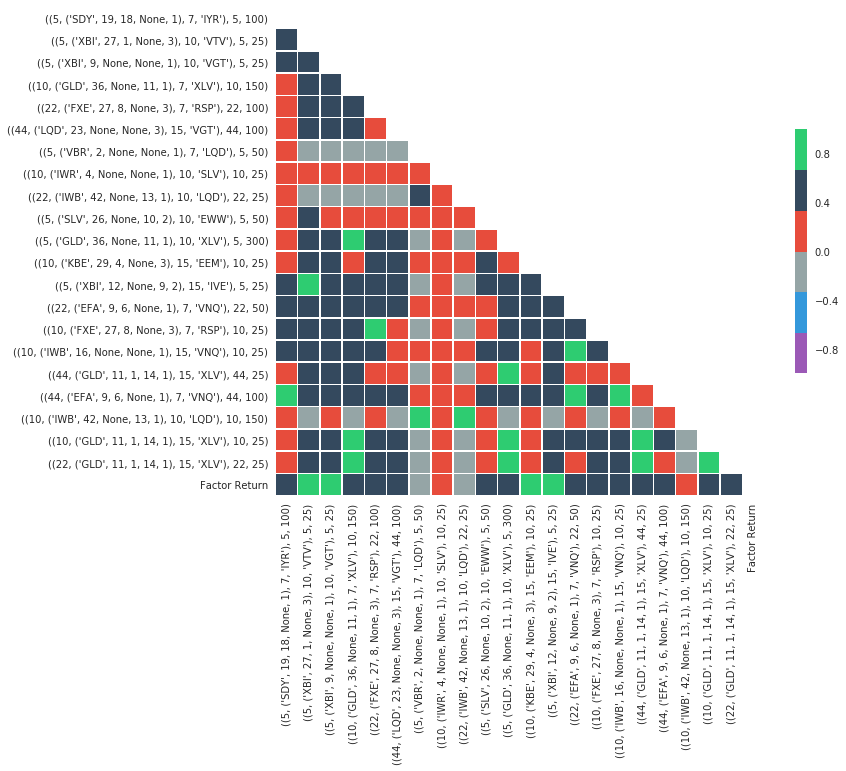

,"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)","((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)","((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)","((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)","((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)","((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)","((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)","((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)","((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)","((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)",...,"((5, ('XBI', 12, None, 9, 2), 15, 'IVE'), 5, 25)","((22, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 22, 50)","((10, ('FXE', 27, 8, None, 3), 7, 'RSP'), 10, 25)","((10, ('IWB', 16, None, None, 1), 15, 'VNQ'), 10, 25)","((44, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 44, 25)","((44, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 44, 100)","((10, ('IWB', 42, None, 13, 1), 10, 'LQD'), 10, 150)","((10, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 10, 25)","((22, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 22, 25)",Factor Return
"((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)",0.000050,1.401090e-05,1.414222e-05,0.000010,1.451755e-05,1.249806e-05,1.977691e-06,3.075494e-06,1.901818e-06,1.092101e-05,...,1.546457e-05,0.000031,1.451344e-05,0.000028,6.394041e-06,0.000041,1.938698e-06,7.759461e-06,7.624599e-06,3.558007e-05
"((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)",0.000014,2.513031e-05,1.919797e-05,0.000017,1.884310e-05,1.375705e-05,-8.034958e-07,5.378593e-06,-6.476015e-07,1.244105e-05,...,1.933556e-05,0.000020,1.515506e-05,0.000018,9.258369e-06,0.000023,-3.203054e-07,1.203971e-05,1.131520e-05,4.309922e-05
"((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)",0.000014,1.919797e-05,3.424222e-05,0.000016,2.196681e-05,2.022986e-05,-6.345645e-07,6.590112e-06,-3.845174e-07,1.120038e-05,...,1.694424e-05,0.000017,1.867579e-05,0.000014,1.103937e-05,0.000023,4.915206e-08,1.240328e-05,1.281248e-05,5.018853e-05
"((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)",0.000010,1.651046e-05,1.571191e-05,0.000042,1.786193e-05,1.318350e-05,-1.186826e-06,1.739957e-06,-1.678873e-06,4.577218e-06,...,1.781448e-05,0.000020,1.614954e-05,0.000019,2.102240e-05,0.000019,-1.306562e-06,1.977797e-05,2.196529e-05,2.991052e-05
"((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)",0.000015,1.884310e-05,2.196681e-05,0.000018,4.024086e-05,9.967612e-06,-6.841043e-07,5.115657e-06,-9.745468e-08,1.133680e-05,...,1.821986e-05,0.000018,2.574608e-05,0.000020,1.031870e-05,0.000021,1.122126e-07,1.178320e-05,1.177592e-05,4.341576e-05
"((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)",0.000012,1.375705e-05,2.022986e-05,0.000013,9.967612e-06,3.383077e-05,-2.234118e-07,4.308439e-06,-5.122085e-07,1.124368e-05,...,1.291069e-05,0.000016,1.096128e-05,0.000013,9.668644e-06,0.000017,-3.579147e-07,9.543361e-06,9.842929e-06,3.147244e-05
"((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)",0.000002,-8.034958e-07,-6.345645e-07,-0.000001,-6.841043e-07,-2.234118e-07,3.976265e-06,4.937196e-07,2.888105e-06,6.429831e-07,...,-8.493964e-07,0.000002,-4.345762e-07,0.000001,-6.529929e-07,0.000002,3.163302e-06,-7.499343e-07,-6.183798e-07,-8.712650e-07
"((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)",0.000003,5.378593e-06,6.590112e-06,0.000002,5.115657e-06,4.308439e-06,4.937196e-07,6.721033e-05,2.335555e-07,8.045787e-06,...,6.272327e-06,0.000006,4.258247e-06,0.000005,1.611230e-06,0.000007,1.612654e-07,1.558655e-06,8.566745e-07,1.636703e-05
"((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)",0.000002,-6.476015e-07,-3.845174e-07,-0.000002,-9.745468e-08,-5.122085e-07,2.888105e-06,2.335555e-07,5.059060e-06,1.290530e-06,...,-7.753110e-07,0.000001,-2.810097e-07,0.000002,-2.736555e-07,0.000002,4.156362e-06,-7.462688e-07,-4.057015e-07,-1.827152e-07
"((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)",0.000011,1.244105e-05,1.120038e-05,0.000005,1.133680e-05,1.124368e-05,6.429831e-07,8.045787e-06,1.290530e-06,3.579312e-05,...,1.062293e-05,0.000014,7.802912e-06,0.000014,6.336073e-06,0.000018,1.456944e-06,6.420054e

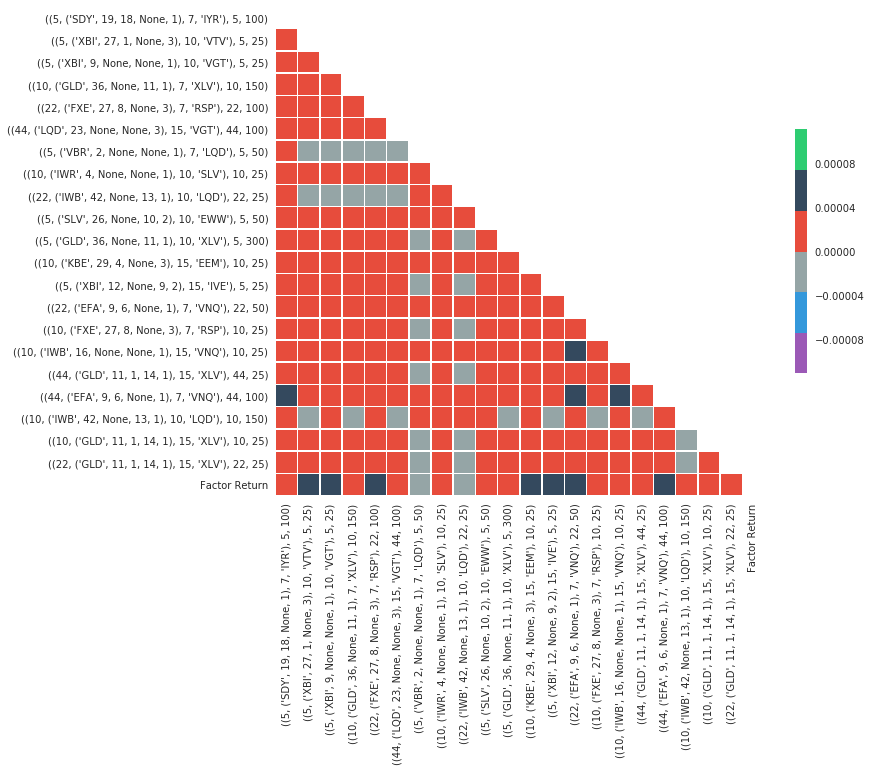

In [41]:
%matplotlib inline
portfolioGeneration.visualizeModels(modelReturnsWithFactor)

In [10]:
portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)

[]
((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
NEED TO STORE 2096
((5, ('XBI', 27, 1, None, 3), 10, 'VTV'), 5, 25)
NEED TO STORE 2096
((5, ('XBI', 9, None, None, 1), 10, 'VGT'), 5, 25)
NEED TO STORE 2096
((10, ('GLD', 36, None, 11, 1), 7, 'XLV'), 10, 150)
NEED TO STORE 2096
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
NEED TO STORE 2096
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
NEED TO STORE 2096
((5, ('VBR', 2, None, None, 1), 7, 'LQD'), 5, 50)
NEED TO STORE 2096
((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)
NEED TO STORE 2096
((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)
NEED TO STORE 2096
((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)
NEED TO STORE 2096
((5, ('GLD', 36, None, 11, 1), 10, 'XLV'), 5, 300)
NEED TO STORE 2096
((10, ('KBE', 29, 4, None, 3), 15, 'EEM'), 10, 25)
NEED TO STORE 2096
((5, ('XBI', 12, None, 9, 2), 15, 'IVE'), 5, 25)
NEED TO STORE 2096
((22, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 22, 50)
NEED TO STORE 2096
((10, ('FXE', 27, 

In [18]:
portfolioHash = portfolioGeneration.storePortfolio(uniqueModels,\
            description="Small Portfolio with Unique Models", benchmark=factorToTrade, portfolioType="EW By Ticker")
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
display(portfolioInfo)

PORTFOLIO HASH: 443958fe526d5b10a120afb1acf292b2e21a9c112da6aa22bfd89d09
1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075
2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa
2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a
3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22
43f88763edefd7af535eb11152055d8f83a70858286b6daa4319b127
4d69d02e283395358524757cf4ad40ffb4d5a1629a0591aa402fb5d1
525cf44e8172173b3f57b5f8b993b990f74dbe4f6ebf25cee659edc8
6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
6b7dc2dcdc33c1821c5c7fefcc9aa5857a8af3da2e9a65781f5645ad
759581b497bcd8f07c66fede156ce5c6d1fe826b0192a98f030742a7
7d0babac85bd5240804bca4fd99b925e30f55a7d299076ee21ce25ee
851fd8e7b78397eaa2cabf4c630f1c9241a65638c1c8670d34dabcfd
8f9d61400bc832f5b1af1cbac268de277f955a2aad6ae71c3e7fc4da
98f0c247c49553f0637560916983adb0645ada412ca8548f7ab70f89
b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad
bc43e4c9a00c0e3749c0ba7906dc31a0bda35e01f302abf87aeb7d7a
bfb692680043226

<Entity('walkforward_portfolio_info', '443958fe526d5b10a120afb1acf292b2e21a9c112da6aa22bfd89d09') {'startedTrading': datetime.datetime(2017, 8, 18, 0, 0, tzinfo=<UTC>), 'benchmark': 'SPY', 'description': 'Small Portfolio with Unique Models', 'portfolioType': 'EW By Ticker'}>

In [19]:
modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
display(modelHashes)

['2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa',
 '759581b497bcd8f07c66fede156ce5c6d1fe826b0192a98f030742a7',
 'bc43e4c9a00c0e3749c0ba7906dc31a0bda35e01f302abf87aeb7d7a',
 '1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075',
 '8f9d61400bc832f5b1af1cbac268de277f955a2aad6ae71c3e7fc4da',
 '525cf44e8172173b3f57b5f8b993b990f74dbe4f6ebf25cee659edc8',
 '6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f',
 'fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006',
 '3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22',
 '4d69d02e283395358524757cf4ad40ffb4d5a1629a0591aa402fb5d1',
 '98f0c247c49553f0637560916983adb0645ada412ca8548f7ab70f89',
 'e5b77ac840e0694f124e4ceb80219238646ec98c98391057e8b5095e',
 '2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a',
 'de51d3387dba4ff1c7191d771fff8acb8c714379633023cd249c2d0e',
 '6b7dc2dcdc33c1821c5c7fefcc9aa5857a8af3da2e9a65781f5645ad',
 '7d0babac85bd5240804bca4fd99b925e30f55a7d299076ee21ce25ee',
 'c155c65771efa17daaafbd

In [20]:
allModels = portfolio.getModelsByKey(modelHashes)
display(allModels)

In [21]:
aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
display(aggregateReturns)

,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,525cf44e8172173b3f57b5f8b993b990f74dbe4f6ebf25cee659edc8,e5b77ac840e0694f124e4ceb80219238646ec98c98391057e8b5095e,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,6b7dc2dcdc33c1821c5c7fefcc9aa5857a8af3da2e9a65781f5645ad,851fd8e7b78397eaa2cabf4c630f1c9241a65638c1c8670d34dabcfd,bfb69268004322605e67a1d50f2565c8475076e986b2f0a53c76ad45,de51d3387dba4ff1c7191d771fff8acb8c714379633023cd249c2d0e,...,43f88763edefd7af535eb11152055d8f83a70858286b6daa4319b127,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,4d69d02e283395358524757cf4ad40ffb4d5a1629a0591aa402fb5d1,759581b497bcd8f07c66fede156ce5c6d1fe826b0192a98f030742a7,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a,98f0c247c49553f0637560916983adb0645ada412ca8548f7ab70f89,c155c65771efa17daaafbd3ee1c327d5b1843eade842874a01566d43,7d0babac85bd5240804bca4fd99b925e30f55a7d299076ee21ce25ee,8f9d61400bc832f5b1af1cbac268de277f955a2aad6ae71c3e7fc4da,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
2009-01-16,-0.004212,0.002293,-0.007813,-0.043052,-0.009976,-7.392898e-03,0.010506,-0.000124,-0.017509,-0.003433,...,-0.000352,-0.015188,-8.952337e-04,-0.024109,0.010858,-0.045228,-5.746823e-03,0.022214,0.049614,-0.001005
2009-01-20,0.004849,-0.002836,0.006532,0.041820,0.007413,-7.816508e-05,-0.016376,0.000000,0.006550,0.002561,...,0.001618,0.017100,-3.712842e-04,0.015181,-0.007562,0.032624,-2.149540e-03,-0.017874,-0.047041,0.000759
2009-01-21,-0.002731,-0.000721,0.001266,-0.018660,-0.002286,-0.000000e+00,0.012018,0.000050,-0.001717,0.000430,...,0.002766,-0.006353,-3.504899e-04,-0.004656,-0.001208,-0.019631,-1.759751e-03,0.005822,0.024861,-0.000665
2009-01-22,0.001344,-0.000000,0.000000,0.011442,0.000828,-1.031153e-04,-0.005725,-0.000012,-0.000954,0.000000,...,0.009143,0.002967,-7.475859e-04,0.001533,-0.000000,0.007384,-3.338358e-03,-0.001582,-0.013872,0.000613
2009-01-23,0.000802,0.001122,-0.001351,0.007123,0.000162,-4.213072e-04,0.001420,-0.000045,0.000178,-0.000300,...,0.000865,-0.000774,-1.211258e-03,0.000594,0.000721,0.006918,-4.932805e-03,-0.000455,0.002582,0.000356
2009-01-26,0.002639,-0.004915,0.005115,0.013931,-0.000359,2.936876e-04,-0.004018,-0.000009,-0.000893,0.000788,...,-0.000821,0.000855,3.010298e-03,0.001683,-0.001934,0.010136,1.101328e-02,-0.005488,-0.006463,0.001893
2009-01-27,0.009875,-0.003986,0.003616,0.026390,-0.001937,4.999355e-04,-0.020278,-0.000148,-0.010815,0.000281,...,0.000152,0.000000,1.515429e-03,0.003814,-0.001461,0.028722,4.968109e-03,-0.015385,-0.038813,0.008263
2009-01-28,-0.010501,0.003689,-0.003057,-0.026384,0.003196,-1.118078e-03,0.024300,0.000221,0.008953,0.000012,...,0.005665,-0.002446,-2.585556e-03,-0.004886,0.001322,-0.028286,-7.849840e-03,0.015035,0.036290,-0.010383
2009-01-29,-0.006139,0.002751,-0.002121,-0.022286,0.003764,6.579549e-04,0.014787,0.000090,0.003857,0.000207,...,0.003272,0.000991,1.754546e-03,-0.004929,0.000821,-0.004280,4.852417e-03,0.009926,0.017941,-0.010352
2009-01-30,-0.001263,-0.001731,0.001189,0.010926,-0.002387,-7.436648e-04,-0.007625,0.000094,-0.002288,-0.000238,...,-0.003143,-0.000568,-1.366484e-03,-0.000335,-0.000697,-0.005330,-3.439450e-03,0.001264,-0.010425,-0.000737


In [22]:
cleanedAggregateReturns = aggregateReturns.dropna()
cleanedAggregatePredictions = aggregatePredictions.dropna()
display(cleanedAggregateReturns)
display(cleanedAggregatePredictions)

,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,525cf44e8172173b3f57b5f8b993b990f74dbe4f6ebf25cee659edc8,e5b77ac840e0694f124e4ceb80219238646ec98c98391057e8b5095e,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,6b7dc2dcdc33c1821c5c7fefcc9aa5857a8af3da2e9a65781f5645ad,851fd8e7b78397eaa2cabf4c630f1c9241a65638c1c8670d34dabcfd,bfb69268004322605e67a1d50f2565c8475076e986b2f0a53c76ad45,de51d3387dba4ff1c7191d771fff8acb8c714379633023cd249c2d0e,...,43f88763edefd7af535eb11152055d8f83a70858286b6daa4319b127,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,4d69d02e283395358524757cf4ad40ffb4d5a1629a0591aa402fb5d1,759581b497bcd8f07c66fede156ce5c6d1fe826b0192a98f030742a7,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a,98f0c247c49553f0637560916983adb0645ada412ca8548f7ab70f89,c155c65771efa17daaafbd3ee1c327d5b1843eade842874a01566d43,7d0babac85bd5240804bca4fd99b925e30f55a7d299076ee21ce25ee,8f9d61400bc832f5b1af1cbac268de277f955a2aad6ae71c3e7fc4da,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
2009-01-16,-0.004212,0.002293,-0.007813,-0.043052,-0.009976,-7.392898e-03,0.010506,-0.000124,-0.017509,-0.003433,...,-0.000352,-0.015188,-8.952337e-04,-0.024109,0.010858,-0.045228,-5.746823e-03,0.022214,0.049614,-0.001005
2009-01-20,0.004849,-0.002836,0.006532,0.041820,0.007413,-7.816508e-05,-0.016376,0.000000,0.006550,0.002561,...,0.001618,0.017100,-3.712842e-04,0.015181,-0.007562,0.032624,-2.149540e-03,-0.017874,-0.047041,0.000759
2009-01-21,-0.002731,-0.000721,0.001266,-0.018660,-0.002286,-0.000000e+00,0.012018,0.000050,-0.001717,0.000430,...,0.002766,-0.006353,-3.504899e-04,-0.004656,-0.001208,-0.019631,-1.759751e-03,0.005822,0.024861,-0.000665
2009-01-22,0.001344,-0.000000,0.000000,0.011442,0.000828,-1.031153e-04,-0.005725,-0.000012,-0.000954,0.000000,...,0.009143,0.002967,-7.475859e-04,0.001533,-0.000000,0.007384,-3.338358e-03,-0.001582,-0.013872,0.000613
2009-01-23,0.000802,0.001122,-0.001351,0.007123,0.000162,-4.213072e-04,0.001420,-0.000045,0.000178,-0.000300,...,0.000865,-0.000774,-1.211258e-03,0.000594,0.000721,0.006918,-4.932805e-03,-0.000455,0.002582,0.000356
2009-01-26,0.002639,-0.004915,0.005115,0.013931,-0.000359,2.936876e-04,-0.004018,-0.000009,-0.000893,0.000788,...,-0.000821,0.000855,3.010298e-03,0.001683,-0.001934,0.010136,1.101328e-02,-0.005488,-0.006463,0.001893
2009-01-27,0.009875,-0.003986,0.003616,0.026390,-0.001937,4.999355e-04,-0.020278,-0.000148,-0.010815,0.000281,...,0.000152,0.000000,1.515429e-03,0.003814,-0.001461,0.028722,4.968109e-03,-0.015385,-0.038813,0.008263
2009-01-28,-0.010501,0.003689,-0.003057,-0.026384,0.003196,-1.118078e-03,0.024300,0.000221,0.008953,0.000012,...,0.005665,-0.002446,-2.585556e-03,-0.004886,0.001322,-0.028286,-7.849840e-03,0.015035,0.036290,-0.010383
2009-01-29,-0.006139,0.002751,-0.002121,-0.022286,0.003764,6.579549e-04,0.014787,0.000090,0.003857,0.000207,...,0.003272,0.000991,1.754546e-03,-0.004929,0.000821,-0.004280,4.852417e-03,0.009926,0.017941,-0.010352
2009-01-30,-0.001263,-0.001731,0.001189,0.010926,-0.002387,-7.436648e-04,-0.007625,0.000094,-0.002288,-0.000238,...,-0.003143,-0.000568,-1.366484e-03,-0.000335,-0.000697,-0.005330,-3.439450e-03,0.001264,-0.010425,-0.000737


,1716b710b4c908a8d3e69b0a2f8eefc077c5d67608c5f04d9cb18075,525cf44e8172173b3f57b5f8b993b990f74dbe4f6ebf25cee659edc8,e5b77ac840e0694f124e4ceb80219238646ec98c98391057e8b5095e,2083db1aa7ff59b8962603994801edc673c219bc1d1dfbd623522aaa,3df5c4064d67b85ba4424dcc5a0a1f0e260b36cc5096855479beed22,fce63ca45cf23a15a747a745bb5abc7e4dd97ec9a9c7b2e203977006,6b7dc2dcdc33c1821c5c7fefcc9aa5857a8af3da2e9a65781f5645ad,851fd8e7b78397eaa2cabf4c630f1c9241a65638c1c8670d34dabcfd,bfb69268004322605e67a1d50f2565c8475076e986b2f0a53c76ad45,de51d3387dba4ff1c7191d771fff8acb8c714379633023cd249c2d0e,...,43f88763edefd7af535eb11152055d8f83a70858286b6daa4319b127,b6bfc86cdf3ba24ff32db7f039190bace80978bb9c1b8fddae4175ad,4d69d02e283395358524757cf4ad40ffb4d5a1629a0591aa402fb5d1,759581b497bcd8f07c66fede156ce5c6d1fe826b0192a98f030742a7,2faf49abf1fbcae37bc81114b876dc2cffa988e43c9810c0401c755a,98f0c247c49553f0637560916983adb0645ada412ca8548f7ab70f89,c155c65771efa17daaafbd3ee1c327d5b1843eade842874a01566d43,7d0babac85bd5240804bca4fd99b925e30f55a7d299076ee21ce25ee,8f9d61400bc832f5b1af1cbac268de277f955a2aad6ae71c3e7fc4da,6aa37ddc5e5213a1d76ec495a4fc9207c5fac29cdf5db2f5547ca08f
2009-01-16,0.074219,-0.095703,0.326050,0.828125,0.191895,0.500000,-0.093750,0.001953,0.156250,0.143250,...,0.195312,0.140625,0.060547,0.37500,-0.453125,0.606689,0.388672,-0.374512,-0.442749,0.015625
2009-01-20,0.101562,-0.134766,0.310425,0.839844,0.148865,0.015625,-0.156250,0.000000,0.062500,0.121704,...,0.201172,0.171875,0.074219,0.31250,-0.359375,0.599854,0.429688,-0.382141,-0.448853,0.015625
2009-01-21,0.136719,-0.167969,0.294922,0.863281,0.105774,0.000000,-0.218750,-0.001953,0.031250,0.100159,...,0.205078,0.125000,0.093750,0.21875,-0.281250,0.593262,0.470703,-0.388428,-0.452515,0.031250
2009-01-22,0.175781,-0.197266,0.278992,0.867188,0.062744,0.015625,-0.187500,-0.001953,-0.031250,0.078857,...,0.199219,0.093750,0.113281,0.15625,-0.218750,0.586914,0.505859,-0.393677,-0.454346,0.062500
2009-01-23,0.195312,-0.218750,0.263367,0.871094,0.019836,0.046875,-0.250000,-0.005859,-0.031250,0.058472,...,0.205078,0.093750,0.134766,0.15625,-0.140625,0.579956,0.548828,-0.397583,-0.454468,0.093750
2009-01-26,0.226562,-0.238281,0.247986,0.875000,-0.022522,0.015625,-0.281250,-0.003906,-0.062500,0.038208,...,0.195312,0.046875,0.160156,0.12500,-0.093750,0.573242,0.585938,-0.400269,-0.452393,0.140625
2009-01-27,0.253906,-0.255859,0.232117,0.875000,-0.064209,0.062500,-0.234375,-0.003906,-0.125000,0.018066,...,0.179688,0.000000,0.189453,0.09375,-0.093750,0.566772,0.621094,-0.401489,-0.448608,0.203125
2009-01-28,0.265625,-0.261719,0.216858,0.867188,-0.105042,0.093750,-0.296875,-0.005859,-0.109375,-0.000854,...,0.167969,0.031250,0.216797,0.12500,-0.093750,0.559814,0.658203,-0.401489,-0.443359,0.265625
2009-01-29,0.281250,-0.261719,0.201782,0.855469,-0.144470,0.093750,-0.359375,-0.005859,-0.093750,-0.019653,...,0.154297,-0.031250,0.250000,0.15625,-0.078125,0.552979,0.691406,-0.400085,-0.436035,0.328125
2009-01-30,0.304688,-0.271484,0.186523,0.835938,-0.182617,0.156250,-0.312500,-0.005859,-0.093750,-0.037354,...,0.126953,-0.093750,0.287109,0.15625,-0.109375,0.546631,0.722656,-0.397583,-0.427246,0.343750


In [23]:
if portfolioInfo["portfolioType"] == "HRP FULL":
    print("HRP FULL")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            126, startIndex=None, maxWindowSize=False)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "HRP WINDOW":
    print("HRP WINDOW")
    ##HRP ALLOCATION
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
            126, startIndex=None, maxWindowSize=True)
    print("COMPUTED HISTORICAL WEIGHTS")
    display(historicalWeights)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW":
    print("EW")
    ##EW ALLOCATION
    ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                     None)
    display(ewReturns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
elif portfolioInfo["portfolioType"] == "EW By Ticker":
    print("EW By Ticker")
    weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
    historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
    portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                    allModels, historicalWeights, cleanedAggregatePredictions)
    

EW By Ticker


In [24]:
portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
portfolioInfo = {
    "key":portfolioInfo.key.name,
    "description":portfolioInfo["description"],
    "benchmark":portfolioInfo["benchmark"],
    "portfolioType":portfolioInfo["portfolioType"],
    "startedTrading":portfolioInfo["startedTrading"]
}
print(portfolioInfo)
portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData, portfolioInfo["startedTrading"])
portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

{'key': '443958fe526d5b10a120afb1acf292b2e21a9c112da6aa22bfd89d09', 'description': 'Small Portfolio with Unique Models', 'benchmark': 'SPY', 'portfolioType': 'EW By Ticker', 'startedTrading': datetime.datetime(2017, 8, 18, 0, 0, tzinfo=<UTC>)}
((10, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 10, 25)
((5, ('SLV', 26, None, 10, 2), 10, 'EWW'), 5, 50)
((5, ('SDY', 19, 18, None, 1), 7, 'IYR'), 5, 100)
((10, ('IWB', 16, None, None, 1), 15, 'VNQ'), 10, 25)
((44, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 44, 100)
((22, ('EFA', 9, 6, None, 1), 7, 'VNQ'), 22, 50)
((44, ('GLD', 11, 1, 14, 1), 15, 'XLV'), 44, 25)
((22, ('FXE', 27, 8, None, 3), 7, 'RSP'), 22, 100)
((44, ('LQD', 23, None, None, 3), 15, 'VGT'), 44, 100)
((10, ('IWR', 4, None, None, 1), 10, 'SLV'), 10, 25)
((5, ('XBI', 12, None, 9, 2), 15, 'IVE'), 5, 25)
((22, ('IWB', 42, None, 13, 1), 10, 'LQD'), 22, 25)
((10, ('FXE', 27, 8, None, 3), 7, 'RSP'), 10, 25)
((10, ('KBE', 29, 4, None, 3), 15, 'EEM'), 10, 25)
((10, ('IWB', 42, None, 13, 1), 10, 'LQD'), 

# STORE ALL TICKERS AS OWN MODELS

In [26]:
import importlib
importlib.reload(portfolio)
importlib.reload(portfolioGeneration)

<module 'portfolioGeneration' from '/home/prohb125/walkforwardTrader/portfolioGeneration.py'>

In [3]:
allModels = portfolio.getModels(returnEntireObject=False)
for model in allModels[:3]:
    factorToTrade = model.inputSeries.targetTicker
    portfolioHash = portfolioGeneration.getPortfolioHash([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    if portfolio.getPortfolioByKey(portfolioHash) is not None:
        print("ALREADY SAVED", model.describe())
        continue
    
    portfolioHash = portfolioGeneration.storePortfolio([model],\
            description="Model Alone", benchmark=factorToTrade, portfolioType="EW")
    
    ##TEST TO SEE IF ALREADY EXISTS
    
    uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
        computeReturnsForUniqueModelsCache([model], factorToTrade)
    portfolioGeneration.storePastPredictions(uniqueModels, modelPredictions)
    
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    display(portfolioInfo)
    modelHashes = portfolioGeneration.getPortfolioModels(portfolioHash)
    allModels = portfolio.getModelsByKey(modelHashes)
    aggregateReturns, aggregatePredictions = portfolioGeneration.generateAggregateReturnsPredictions(allModels, joinedData)
    
    cleanedAggregateReturns = aggregateReturns.dropna()
    cleanedAggregatePredictions = aggregatePredictions.dropna()
    if portfolioInfo["portfolioType"] == "HRP FULL":
        print("HRP FULL")
        ##HRP ALLOCATION
        hrpReturns, historicalWeights = portfolioGeneration.\
                produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                126, startIndex=None, maxWindowSize=False)
        print("COMPUTED HISTORICAL WEIGHTS")
        display(historicalWeights)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "HRP WINDOW":
        print("HRP WINDOW")
        ##HRP ALLOCATION
        hrpReturns, historicalWeights = portfolioGeneration.\
                produceHRPPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                126, startIndex=None, maxWindowSize=True)
        print("COMPUTED HISTORICAL WEIGHTS")
        display(historicalWeights)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW":
        print("EW")
        ##EW ALLOCATION
        ewReturns = portfolioGeneration.produceEWPredictions(cleanedAggregateReturns[[portfolio.getModelHash(model) for model in allModels]],\
                                         None)
        display(ewReturns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: [1.0/len(x) for item in x], axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    elif portfolioInfo["portfolioType"] == "EW By Ticker":
        print("EW By Ticker")
        weightArray = portfolioGeneration.getWeightingForAlgos(allModels, cleanedAggregateReturns.columns)
        historicalWeights = pd.DataFrame(cleanedAggregateReturns.apply(lambda x: weightArray, axis=1), columns=cleanedAggregateReturns.columns.values)
        portfolioGeneration.storeHistoricalAllocations(portfolioHash, \
                        allModels, historicalWeights, cleanedAggregatePredictions)
    
    portfolioInfo = portfolio.getPortfolioByKey(portfolioHash)
    portfolioInfo = {
        "key":portfolioInfo.key.name,
        "description":portfolioInfo["description"],
        "benchmark":portfolioInfo["benchmark"],
        "portfolioType":portfolioInfo["portfolioType"],
        "startedTrading":portfolioInfo["startedTrading"]
    }
    print(portfolioInfo)
    portfolioData = portfolioGeneration.getDataForPortfolio(portfolioHash, factorToTrade, joinedData, portfolioInfo["startedTrading"])
    portfolioGeneration.cachePortfolio(portfolioInfo, portfolioData, params.AVAILABLE_MODE)

PORTFOLIO HASH: f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac
016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
IYR
ATTEMPTING PULL 016b0ddc5c91859908d1a714c111ea0b31773a12d78eab69a2f68d0e
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
NEED TO STORE 2252


<Entity('walkforward_portfolio_info', 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'description': 'Model Alone', 'portfolioType': 'EW', 'benchmark': 'IYR'}>

EW


,0
2008-08-11,-1.352006e-06
2008-08-12,-1.968072e-06
2008-08-13,3.038465e-06
2008-08-14,-4.981445e-07
2008-08-15,-7.634072e-06
2008-08-18,-8.828504e-06
2008-08-19,1.287826e-06
2008-08-20,-9.136455e-06
2008-08-21,1.813030e-05
2008-08-22,-2.431116e-05


{'key': 'f25cc28585c465a5d130874dde5f38bff49719b15ff10727bed873ac', 'description': 'Model Alone', 'benchmark': 'IYR', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('SDY', 19, 18, None, 1), 15, 'IYR'), 5, 100)
PORTFOLIO HASH: 97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c
050488c6e0df18e029696590d4ba146069d4b8f11886e859441c63a4
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
VTV
ATTEMPTING PULL 050488c6e0df18e029696590d4ba146069d4b8f11886e859441c63a4
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
NEED TO STORE 2208


<Entity('walkforward_portfolio_info', '97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'benchmark': 'VTV', 'portfolioType': 'EW', 'description': 'Model Alone'}>

EW


,0
2008-10-16,5.732584e-07
2008-10-17,-6.127344e-06
2008-10-20,4.424482e-06
2008-10-21,1.488095e-05
2008-10-22,-3.395755e-06
2008-10-23,1.055338e-05
2008-10-24,1.170834e-05
2008-10-27,-5.913131e-05
2008-10-28,1.263842e-05
2008-10-29,-1.920362e-05


{'key': '97b325eafc41e99f810e47cf44540480184559c7120c0f80a48c433c', 'description': 'Model Alone', 'benchmark': 'VTV', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('XBI', 27, 1, None, 3), 15, 'VTV'), 5, 100)
PORTFOLIO HASH: c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3
10184f6ec13c258148064a8c007add65b837f4904e939b71e276b749
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
VGT
ATTEMPTING PULL 10184f6ec13c258148064a8c007add65b837f4904e939b71e276b749
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
NEED TO STORE 2228


<Entity('walkforward_portfolio_info', 'c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3') {'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>), 'benchmark': 'VGT', 'description': 'Model Alone', 'portfolioType': 'EW'}>

EW


,0
2008-09-17,-2.319197e-06
2008-09-18,0.000000e+00
2008-09-19,-2.202156e-06
2008-09-22,4.785284e-07
2008-09-23,-2.250995e-07
2008-09-24,-2.159103e-06
2008-09-25,-7.955919e-07
2008-09-26,2.438499e-05
2008-09-29,-1.628945e-05
2008-09-30,1.141555e-05


{'key': 'c5fce4f49b7d36f81c0b4c75398e99390fa0b8bbd27f4365769e86a3', 'description': 'Model Alone', 'benchmark': 'VGT', 'portfolioType': 'EW', 'startedTrading': datetime.datetime(2017, 8, 17, 0, 0, tzinfo=<UTC>)}
((5, ('XBI', 9, None, None, 1), 15, 'VGT'), 5, 100)
